Layer (type:depth-idx)                   Input Shape          Output Shape         Kernel Shape         Param #              Mult-Adds            Trainable
VisionTransformer                        [64, 3, 32, 32]      [64, 100]            --                   16,896               --                   True
├─PatchEmbedding: 1-1                    [64, 3, 32, 32]      [64, 64, 256]        --                   --                   --                   True
│    └─Conv2d: 2-1                       [64, 3, 32, 32]      [64, 256, 8, 8]      [4, 4]               12,544               51,380,224           True
├─Dropout: 1-2                           [64, 65, 256]        [64, 65, 256]        --                   --                   --                   --
├─ModuleList: 1-3                        --                   --                   --                   --                   --                   True
│    └─TransformerEncoder: 2-2           [64, 65, 256]        [64, 65, 256]        --      

Epoch 1/1:   0%|          | 2/782 [00:00<00:45, 17.17it/s, loss=4.7540, acc=1.79%]

Input images shape: torch.Size([64, 3, 32, 32])
Labels shape: torch.Size([64])
Labels values: tensor([71, 76,  0, 17, 59, 27,  5, 32, 27, 59], device='cuda:0')
Model outputs shape: torch.Size([64, 100])
Expected outputs shape: torch.Size([64, 100])


Epoch 1/1: 100%|██████████| 782/782 [00:12<00:00, 62.67it/s, loss=4.6103, acc=0.93%]


Epoch 1/1 - Loss: 4.6295, Accuracy: 0.93%

Testing started...


Testing: 100%|██████████| 157/157 [00:01<00:00, 97.24it/s, accuracy=1.00%]


Final Test Loss: 4.6205, Final Test Accuracy: 1.00%

Visualizing results...


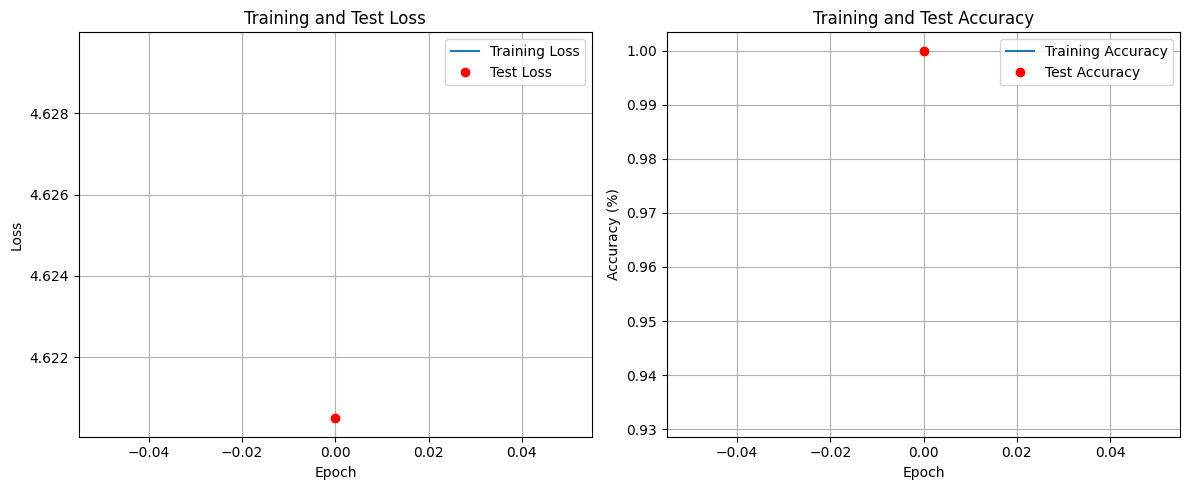

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader 
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from torchinfo import summary
import gc


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
image_size = 32
patch_size = 4
num_classes = 100
num_epochs = 50
batch_size = 64
learning_rate = 0.0001
num_heads = 4
num_layers = 4
hidden_dim = 256
mlp_dim = 512

# Data preparation
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# CIFAR-100 dataset
train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                           download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                          download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Patch embedding layer
class PatchEmbedding(nn.Module):
    def __init__(self, image_size, patch_size, in_channels=3, embed_dim=256):
        super().__init__()
        self.num_patches = (image_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, 
                            kernel_size=patch_size, stride=patch_size)
        
    def forward(self, x):
        x = self.proj(x)  # [B, embed_dim, H', W']
        x = x.flatten(2)  # [B, embed_dim, num_patches]
        x = x.transpose(1, 2)  # [B, num_patches, embed_dim]
        return x

# Transformer Encoder
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.1):
        super().__init__()
        self.layer_norm1 = nn.LayerNorm(embed_dim)
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.layer_norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, embed_dim),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        x2 = self.layer_norm1(x)
        attention_output, _ = self.attention(x2, x2, x2)
        x = x + attention_output
        x2 = self.layer_norm2(x)
        mlp_output = self.mlp(x2)
        x = x + mlp_output
        return x

# Vision Transformer
class VisionTransformer(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, embed_dim, 
                 num_heads, num_layers, mlp_dim, dropout=0.1):
        super().__init__()
        self.patch_embed = PatchEmbedding(image_size, patch_size, 3, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        num_patches = (image_size // patch_size) ** 2
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.dropout = nn.Dropout(dropout)
        
        self.transformer = nn.ModuleList(
            [TransformerEncoder(embed_dim, num_heads, mlp_dim, dropout) 
             for _ in range(num_layers)]
        )
        
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
        
    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.dropout(x)
        
        for transformer in self.transformer:
            x = transformer(x)
            
        x = self.layer_norm(x)
        cls_token_final = x[:, 0]
        x = self.head(cls_token_final)
        return x

# Initialize model
model = VisionTransformer(
    image_size=image_size,
    patch_size=patch_size,
    num_classes=num_classes,
    embed_dim=hidden_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    mlp_dim=mlp_dim
).to(device)


# Display model summary
summary(model, 
        input_size=(batch_size, 3, image_size, image_size),
        col_names=["input_size", "output_size", "kernel_size", "num_params", "mult_adds", "trainable"],
        col_width=20,
        depth=5,
        verbose=True,
        device=device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
def train():
    model.train()
    train_losses = []
    train_accuracies = []
    
    for epoch in range(num_epochs):
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, (images, labels) in enumerate(progress_bar):
            images = images.to(device)
            labels = labels.to(device)
            
            # Debug information
            if i == 0 and epoch == 0:
                print(f"Input images shape: {images.shape}")
                print(f"Labels shape: {labels.shape}")
                print(f"Labels values: {labels[:10]}")  # Print first 10 labels
            
            # Forward pass
            outputs = model(images)
            
            # Debug information
            if i == 0 and epoch == 0:
                print(f"Model outputs shape: {outputs.shape}")
                print(f"Expected outputs shape: {torch.Size([batch_size, num_classes])}")
            
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()
            
            # Update progress bar
            progress_bar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100 * correct / total:.2f}%'
            })
        
        # Calculate epoch metrics
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        
        # Store metrics
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        # Print epoch summary
        print(f'Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')
    
    return train_losses, train_accuracies

# Test the model
def test():
    model.eval()
    test_losses = []
    test_accuracies = []
    
    with torch.no_grad():
        correct = 0
        total = 0
        running_loss = 0.0
        progress_bar = tqdm(test_loader, desc='Testing')
        
        for images, labels in progress_bar:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()
            
            # Update progress bar with current accuracy
            accuracy = 100 * correct / total
            progress_bar.set_postfix({'accuracy': f'{accuracy:.2f}%'})
        
        # Calculate final metrics
        final_loss = running_loss / len(test_loader)
        final_acc = 100 * correct / total
        
        # Store metrics
        test_losses.append(final_loss)
        test_accuracies.append(final_acc)
        
        print(f'Final Test Loss: {final_loss:.4f}, Final Test Accuracy: {final_acc:.2f}%')
    
    return test_losses, test_accuracies

# Visualize training and testing results
def visualize_results(train_losses, train_accuracies, test_losses, test_accuracies):
    plt.figure(figsize=(12, 5))
    
    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot([len(train_losses)-1], test_losses, 'ro', label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot([len(train_accuracies)-1], test_accuracies, 'ro', label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Test Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('vit_training_results.png')
    plt.show()

# Run training and testing
if __name__ == '__main__':
    print("Training started...")
    train_losses, train_accuracies = train()
    print("\nTesting started...")
    test_losses, test_accuracies = test()
    
    # Visualize results
    print("\nVisualizing results...")
    visualize_results(train_losses, train_accuracies, test_losses, test_accuracies)


Layer (type:depth-idx)                   Input Shape          Output Shape         Kernel Shape         Param #              Mult-Adds            Trainable
VisionTransformer                        [64, 3, 32, 32]      [64, 100]            --                   16,896               --                   True
├─PatchEmbedding: 1-1                    [64, 3, 32, 32]      [64, 64, 256]        --                   --                   --                   True
│    └─Conv2d: 2-1                       [64, 3, 32, 32]      [64, 256, 8, 8]      [4, 4]               12,544               51,380,224           True
├─Dropout: 1-2                           [64, 65, 256]        [64, 65, 256]        --                   --                   --                   --
├─ModuleList: 1-3                        --                   --                   --                   --                   --                   True
│    └─TransformerEncoder: 2-2           [64, 65, 256]        [64, 65, 256]        --      

Epoch 1/1:   0%|          | 0/782 [00:00<?, ?it/s, loss=4.7927, acc=0.78%]

Epoch 1/1:   1%|          | 6/782 [00:00<00:13, 58.95it/s, loss=4.7882, acc=1.56%]

Input images shape: torch.Size([64, 3, 32, 32])
Labels shape: torch.Size([64])
Labels values: tensor([26, 29, 71, 97, 74, 11, 21, 80, 46, 54], device='cuda:0')
Model outputs shape: torch.Size([64, 100])
Expected outputs shape: torch.Size([64, 100])


Epoch 1/1: 100%|██████████| 782/782 [00:12<00:00, 64.22it/s, loss=4.6611, acc=1.02%]


Epoch 1/1 - Loss: 4.6283, Accuracy: 1.02%

Testing started...


Testing: 100%|██████████| 157/157 [00:01<00:00, 98.50it/s, accuracy=1.00%]


Final Test Loss: 4.6211, Final Test Accuracy: 1.00%

Visualizing results...


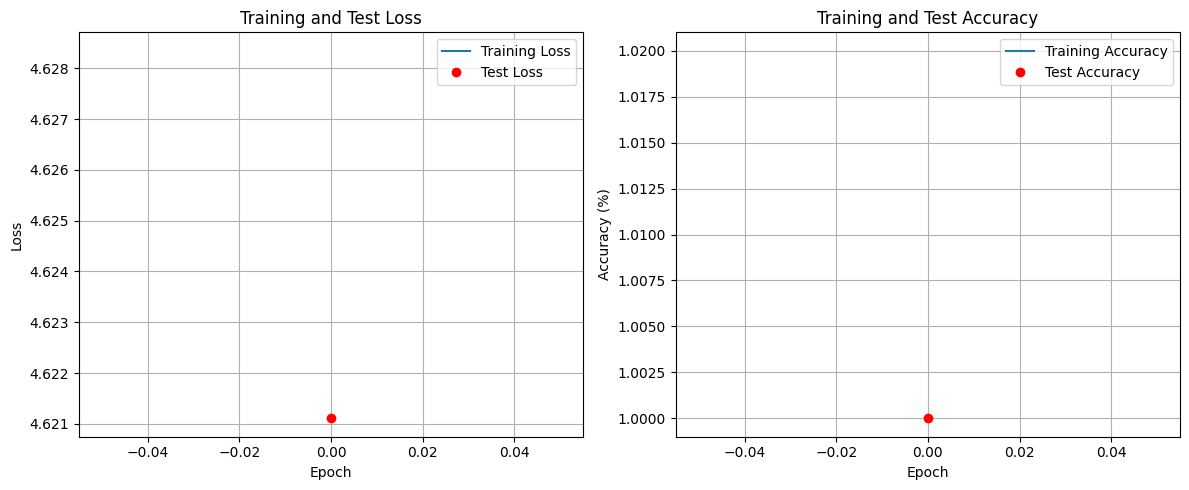

In [ ]:
#ViT from scratch - 8x8 patch size

# Delete model and optimizer variables
del model, optimizer, test_losses, test_accuracies, train_losses, train_accuracies

# Clear CUDA cache if using GPU
gc.collect()
# Clear CUDA cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    
    
# Initialize model
model = VisionTransformer(
    image_size=image_size,
    patch_size=patch_size,
    num_classes=num_classes,
    embed_dim=hidden_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    mlp_dim=mlp_dim
).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Display model summary
summary(model, 
        input_size=(batch_size, 3, image_size, image_size),
        col_names=["input_size", "output_size", "kernel_size", "num_params", "mult_adds", "trainable"],
        col_width=20,
        depth=5,
        verbose=True,
        device=device)

# Hyperparameters
image_size = 32
patch_size = 8
num_classes = 100
num_epochs = 50
batch_size = 64
learning_rate = 0.0001
num_heads = 4
num_layers = 4
hidden_dim = 256
mlp_dim = 512

# Run training and testing
if __name__ == '__main__':
    print("Training started...")
    train_losses, train_accuracies = train()
    print("\nTesting started...")
    test_losses, test_accuracies = test()
    
    # Visualize results
    print("\nVisualizing results...")
    visualize_results(train_losses, train_accuracies, test_losses, test_accuracies)


Layer (type:depth-idx)                   Input Shape          Output Shape         Kernel Shape         Param #              Mult-Adds            Trainable
VisionTransformer                        [64, 3, 32, 32]      [64, 100]            --                   4,608                --                   True
├─PatchEmbedding: 1-1                    [64, 3, 32, 32]      [64, 16, 256]        --                   --                   --                   True
│    └─Conv2d: 2-1                       [64, 3, 32, 32]      [64, 256, 4, 4]      [8, 8]               49,408               50,593,792           True
├─Dropout: 1-2                           [64, 17, 256]        [64, 17, 256]        --                   --                   --                   --
├─ModuleList: 1-3                        --                   --                   --                   --                   --                   True
│    └─TransformerEncoder: 2-2           [64, 17, 256]        [64, 17, 256]        --      

Epoch 1/1:   1%|          | 8/782 [00:00<00:10, 72.50it/s, loss=4.6871, acc=1.23%]

Input images shape: torch.Size([64, 3, 32, 32])
Labels shape: torch.Size([64])
Labels values: tensor([78, 94, 56, 87, 99, 60, 12,  6, 91, 97], device='cuda:0')
Model outputs shape: torch.Size([64, 100])
Expected outputs shape: torch.Size([64, 100])


Epoch 1/1: 100%|██████████| 782/782 [00:10<00:00, 75.94it/s, loss=4.6064, acc=0.99%]


Epoch 1/1 - Loss: 4.6303, Accuracy: 0.99%

Testing started...


Testing: 100%|██████████| 157/157 [00:01<00:00, 110.50it/s, accuracy=1.00%]


Final Test Loss: 4.6162, Final Test Accuracy: 1.00%

Visualizing results...


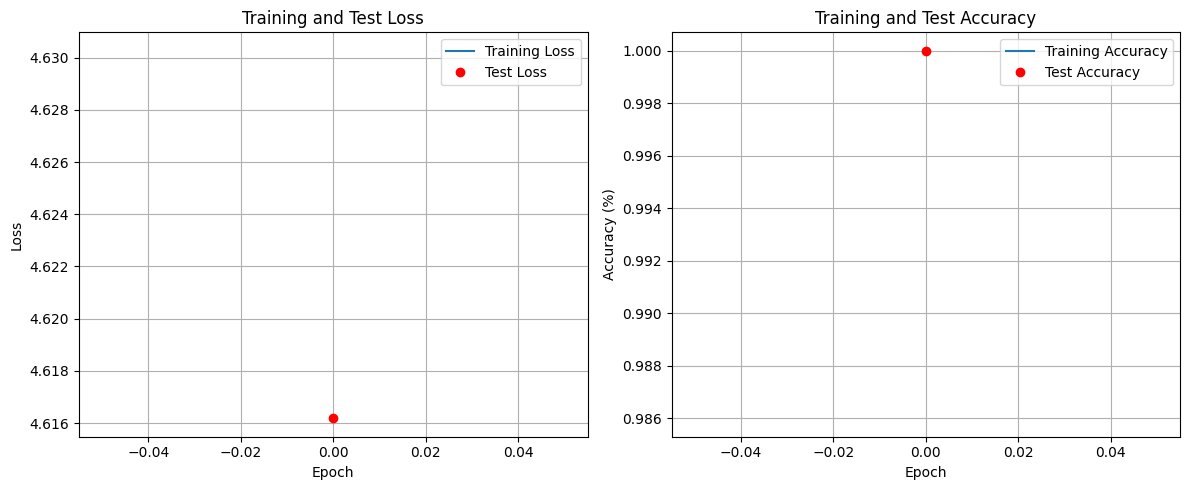

In [3]:
#ViT from scratch - 4x4  patch size - 2 heads 4 layers 256 dim 512 mlp

# Delete model and optimizer variables
del model, optimizer, test_losses, test_accuracies, train_losses, train_accuracies

# Clear CUDA cache if using GPU
gc.collect()
# Clear CUDA cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    

# Initialize model
model = VisionTransformer(
    image_size=image_size,
    patch_size=patch_size,
    num_classes=num_classes,
    embed_dim=hidden_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    mlp_dim=mlp_dim
).to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


# Display model summary
summary(model, 
        input_size=(batch_size, 3, image_size, image_size),
        col_names=["input_size", "output_size", "kernel_size", "num_params", "mult_adds", "trainable"],
        col_width=20,
        depth=5,
        verbose=True,
        device=device)

# Hyperparameters
image_size = 32
patch_size = 4
num_classes = 100
num_epochs = 50
batch_size = 64
learning_rate = 0.0001
num_heads = 2
num_layers = 4
hidden_dim = 256
mlp_dim = 512

# Run training and testing
if __name__ == '__main__':
    print("Training started...")
    train_losses, train_accuracies = train()
    print("\nTesting started...")
    test_losses, test_accuracies = test()
    
    # Visualize results
    print("\nVisualizing results...")
    visualize_results(train_losses, train_accuracies, test_losses, test_accuracies)

In [4]:
#ViT from scratch - 4x4  patch size - 2 heads 8 layers 256 dim 512 mlp

# Delete model and optimizer variables
del model, optimizer, test_losses, test_accuracies, train_losses, train_accuracies

# Clear CUDA cache if using GPU
gc.collect()
# Clear CUDA cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    

# Initialize model
model = VisionTransformer(
    image_size=image_size,
    patch_size=patch_size,
    num_classes=num_classes,
    embed_dim=hidden_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    mlp_dim=mlp_dim
).to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Hyperparameters
image_size = 32
patch_size = 4
num_classes = 100
num_epochs = 50
batch_size = 64
learning_rate = 0.0001
num_heads = 2
num_layers = 8
hidden_dim = 256
mlp_dim = 512

# Run training and testing
if __name__ == '__main__':
    print("Training started...")
    train_losses, train_accuracies = train()
    print("\nTesting started...")
    test_losses, test_accuracies = test()
    
    # Visualize results
    print("\nVisualizing results...")
    visualize_results(train_losses, train_accuracies, test_losses, test_accuracies)

Training started...


Epoch 1/1:   1%|          | 7/782 [00:00<00:12, 61.60it/s, loss=4.7012, acc=1.04%]

Input images shape: torch.Size([64, 3, 32, 32])
Labels shape: torch.Size([64])
Labels values: tensor([46, 40, 79, 74, 79, 76, 13,  6, 29,  6], device='cuda:0')
Model outputs shape: torch.Size([64, 100])
Expected outputs shape: torch.Size([64, 100])


Epoch 1/1: 100%|██████████| 782/782 [00:11<00:00, 66.00it/s, loss=4.5484, acc=0.89%]


Epoch 1/1 - Loss: 4.6299, Accuracy: 0.89%

Testing started...


Testing: 100%|██████████| 157/157 [00:01<00:00, 99.72it/s, accuracy=1.00%]

Final Test Loss: 4.6166, Final Test Accuracy: 1.00%

Visualizing results...


In [5]:
#ViT from scratch - 4x4  patch size - 4 heads 8 layers 256 dim 512 mlp

# Delete model and optimizer variables
del model, optimizer, test_losses, test_accuracies, train_losses, train_accuracies

# Clear CUDA cache if using GPU
gc.collect()
# Clear CUDA cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    

# Initialize model
model = VisionTransformer(
    image_size=image_size,
    patch_size=patch_size,
    num_classes=num_classes,
    embed_dim=hidden_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    mlp_dim=mlp_dim
).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Display model summary
summary(model, 
        input_size=(batch_size, 3, image_size, image_size),
        col_names=["input_size", "output_size", "kernel_size", "num_params", "mult_adds", "trainable"],
        col_width=20,
        depth=5,
        verbose=True,
        device=device)

# Hyperparameters
image_size = 32
patch_size = 4
num_classes = 100
num_epochs = 50
batch_size = 64
learning_rate = 0.0001
num_heads = 4
num_layers = 8
hidden_dim = 256
mlp_dim = 512

# Run training and testing
if __name__ == '__main__':
    print("Training started...")
    train_losses, train_accuracies = train()
    print("\nTesting started...")
    test_losses, test_accuracies = test()
    
    # Visualize results
    print("\nVisualizing results...")
    visualize_results(train_losses, train_accuracies, test_losses, test_accuracies)

Layer (type:depth-idx)                   Input Shape          Output Shape         Kernel Shape         Param #              Mult-Adds            Trainable
VisionTransformer                        [64, 3, 32, 32]      [64, 100]            --                   16,896               --                   True
├─PatchEmbedding: 1-1                    [64, 3, 32, 32]      [64, 64, 256]        --                   --                   --                   True
│    └─Conv2d: 2-1                       [64, 3, 32, 32]      [64, 256, 8, 8]      [4, 4]               12,544               51,380,224           True
├─Dropout: 1-2                           [64, 65, 256]        [64, 65, 256]        --                   --                   --                   --
├─ModuleList: 1-3                        --                   --                   --                   --                   --                   True
│    └─TransformerEncoder: 2-2           [64, 65, 256]        [64, 65, 256]        --      

Epoch 1/1:   0%|          | 0/782 [00:00<?, ?it/s, loss=4.7373, acc=1.04%]

Input images shape: torch.Size([64, 3, 32, 32])
Labels shape: torch.Size([64])
Labels values: tensor([19,  2, 47,  0, 45,  2, 47, 68, 34, 50], device='cuda:0')
Model outputs shape: torch.Size([64, 100])
Expected outputs shape: torch.Size([64, 100])


Epoch 1/1: 100%|██████████| 782/782 [00:17<00:00, 44.97it/s, loss=4.6158, acc=0.94%]


Epoch 1/1 - Loss: 4.6309, Accuracy: 0.94%

Testing started...


Testing: 100%|██████████| 157/157 [00:01<00:00, 81.41it/s, accuracy=1.00%]

Final Test Loss: 4.6188, Final Test Accuracy: 1.00%

Visualizing results...


In [6]:
#ViT from scratch - 4x4  patch size - 4 heads 4 layers 512 dim 1024 mlp

# Delete model and optimizer variables
del model, optimizer, test_losses, test_accuracies, train_losses, train_accuracies

# Clear CUDA cache if using GPU
gc.collect()
# Clear CUDA cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    
# Initialize model
model = VisionTransformer(
    image_size=image_size,
    patch_size=patch_size,
    num_classes=num_classes,
    embed_dim=hidden_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    mlp_dim=mlp_dim
).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Display model summary
summary(model, 
        input_size=(batch_size, 3, image_size, image_size),
        col_names=["input_size", "output_size", "kernel_size", "num_params", "mult_adds", "trainable"],
        col_width=20,
        depth=5,
        verbose=True,
        device=device)

# Hyperparameters
image_size = 32
patch_size = 4
num_classes = 100
num_epochs = 50
batch_size = 64
learning_rate = 0.0001
num_heads = 4
num_layers = 4
hidden_dim = 512
mlp_dim = 1024

# Run training and testing
if __name__ == '__main__':
    print("Training started...")
    train_losses, train_accuracies = train()
    print("\nTesting started...")
    test_losses, test_accuracies = test()
    
    # Visualize results
    print("\nVisualizing results...")
    visualize_results(train_losses, train_accuracies, test_losses, test_accuracies)

Layer (type:depth-idx)                   Input Shape          Output Shape         Kernel Shape         Param #              Mult-Adds            Trainable
VisionTransformer                        [64, 3, 32, 32]      [64, 100]            --                   16,896               --                   True
├─PatchEmbedding: 1-1                    [64, 3, 32, 32]      [64, 64, 256]        --                   --                   --                   True
│    └─Conv2d: 2-1                       [64, 3, 32, 32]      [64, 256, 8, 8]      [4, 4]               12,544               51,380,224           True
├─Dropout: 1-2                           [64, 65, 256]        [64, 65, 256]        --                   --                   --                   --
├─ModuleList: 1-3                        --                   --                   --                   --                   --                   True
│    └─TransformerEncoder: 2-2           [64, 65, 256]        [64, 65, 256]        --      

Epoch 1/1:   0%|          | 0/782 [00:00<?, ?it/s, loss=4.7343, acc=0.52%]

Input images shape: torch.Size([64, 3, 32, 32])
Labels shape: torch.Size([64])
Labels values: tensor([16, 94,  2,  8, 40, 98, 62, 36,  1, 64], device='cuda:0')
Model outputs shape: torch.Size([64, 100])
Expected outputs shape: torch.Size([64, 100])


Epoch 1/1: 100%|██████████| 782/782 [00:18<00:00, 43.13it/s, loss=4.6876, acc=0.96%]


Epoch 1/1 - Loss: 4.6295, Accuracy: 0.96%

Testing started...


Testing: 100%|██████████| 157/157 [00:01<00:00, 79.83it/s, accuracy=1.00%]

Final Test Loss: 4.6225, Final Test Accuracy: 1.00%

Visualizing results...


In [7]:
#problem 2: swin finetuning and "from scratch" comparison
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from transformers import SwinForImageClassification, SwinConfig, AutoImageProcessor
from tqdm import tqdm
import time
import pandas as pd
from copy import deepcopy

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Hyperparameters
num_epochs = 5
batch_size = 32
learning_rate = 2e-5  # Smaller learning rate for fine-tuning
image_size = 224  # Swin expects 224x224 input by default

# Model configurations
models_config = {
    "swin-tiny-pretrained": {
        "name": "microsoft/swin-tiny-patch4-window7-224",
        "pretrained": True,
        "freeze_backbone": True
    },
    "swin-small-pretrained": {
        "name": "microsoft/swin-small-patch4-window7-224",
        "pretrained": True,
        "freeze_backbone": True
    },
    "swin-tiny-scratch": {
        "name": "microsoft/swin-tiny-patch4-window7-224",
        "pretrained": False,
        "freeze_backbone": False
    }
}

# Results tracking
results = {
    "model": [],
    "epoch_train_time": [],
    "test_accuracy": []
}

# CIFAR-100 dataset preparation
def prepare_data(model_name):
    # Data preparation with proper preprocessing for Swin
    processor = AutoImageProcessor.from_pretrained(model_name)
    
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
    ])
    
    # CIFAR-100 dataset
    train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                              download=True, transform=transform)
    test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                             download=True, transform=transform)
    
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

# Create and configure model
def setup_model(config):
    if config["pretrained"]:
        print(f"Loading pretrained {config['name']}...")
        model = SwinForImageClassification.from_pretrained(
            config["name"],
            num_labels=100,  # CIFAR-100 has 100 classes
            ignore_mismatched_sizes=True  # Allows replacing the original classifier head
        ).to(device)
    else:
        print(f"Initializing {config['name']} from scratch...")
        # For scratch training, initialize with the same architecture but random weights
        swin_config = SwinConfig.from_pretrained(
            config["name"],
            num_labels=100  # CIFAR-100 has 100 classes
        )
        model = SwinForImageClassification(swin_config).to(device)
    
    # Freeze backbone parameters if specified
    if config["freeze_backbone"]:
        print("Freezing backbone parameters...")
        for param in model.swin.parameters():
            param.requires_grad = False
        
        # Only the classifier head will be trained
        for param in model.classifier.parameters():
            param.requires_grad = True
        
        # Configure optimizer for fine-tuning (only classifier parameters)
        optimizer = torch.optim.Adam(model.classifier.parameters(), lr=learning_rate)
    else:
        print("Training all parameters...")
        # Configure optimizer for training from scratch (all parameters)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    return model, optimizer

# Training function
def train_model(model, optimizer, train_loader, test_loader, model_name):
    criterion = nn.CrossEntropyLoss()
    epoch_times = []
    
    for epoch in range(num_epochs):
        model.train()
        start_time = time.time()
        progress_bar = tqdm(train_loader, desc=f'Epoch [{epoch+1}/{num_epochs}]')
        
        for i, (images, labels) in enumerate(progress_bar):
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Update progress bar
            if (i+1) % 100 == 0:
                progress_bar.set_postfix({'loss': loss.item()})
        
        epoch_time = time.time() - start_time
        epoch_times.append(epoch_time)
        print(f"Epoch {epoch+1} training time: {epoch_time:.2f} seconds")
    
    # Calculate average epoch time
    avg_epoch_time = sum(epoch_times) / len(epoch_times)
    
    # Test the model
    accuracy = test_model(model, test_loader)
    
    # Store results
    results["model"].append(model_name)
    results["epoch_train_time"].append(avg_epoch_time)
    results["test_accuracy"].append(accuracy)
    
    return avg_epoch_time, accuracy

# Testing function
def test_model(model, test_loader):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in tqdm(test_loader, desc='Testing'):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images).logits
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        print(f'Test Accuracy: {accuracy:.2f}%')
        
        return accuracy

# Main function
def main():
    for model_name, config in models_config.items():
        print(f"\n{'='*50}")
        print(f"Training {model_name}")
        print(f"{'='*50}")
        
        # Prepare data
        train_loader, test_loader = prepare_data(config["name"])
        
        # Setup model
        model, optimizer = setup_model(config)
        
        # Train and test model
        avg_epoch_time, accuracy = train_model(model, optimizer, train_loader, test_loader, model_name)
        
        print(f"Model: {model_name}")
        print(f"Average epoch training time: {avg_epoch_time:.2f} seconds")
        print(f"Test accuracy: {accuracy:.2f}%")
        
        # Clear GPU memory
        del model, optimizer
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
    
    # Create and display results table
    results_df = pd.DataFrame(results)
    print("\nResults Summary:")
    print(results_df.to_string(index=False))
    
    # Save results to CSV
    results_df.to_csv("swin_comparison_results.csv", index=False)
    print("Results saved to swin_comparison_results.csv")
    
    # Print findings for report
    print("\nKey Findings for Report:")
    print("1. Fine-tuning vs. Training from Scratch:")
    ft_acc = results_df[results_df['model'] == 'swin-tiny-pretrained']['test_accuracy'].values[0]
    scratch_acc = results_df[results_df['model'] == 'swin-tiny-scratch']['test_accuracy'].values[0]
    print(f"   - Accuracy difference: {ft_acc - scratch_acc:.2f}%")
    
    print("2. Swin-Tiny vs. Swin-Small:")
    tiny_acc = results_df[results_df['model'] == 'swin-tiny-pretrained']['test_accuracy'].values[0]
    small_acc = results_df[results_df['model'] == 'swin-small-pretrained']['test_accuracy'].values[0]
    print(f"   - Accuracy difference: {small_acc - tiny_acc:.2f}%")
    
    # Note about training times
    tiny_time = results_df[results_df['model'] == 'swin-tiny-pretrained']['epoch_train_time'].values[0]
    small_time = results_df[results_df['model'] == 'swin-small-pretrained']['epoch_train_time'].values[0]
    scratch_time = results_df[results_df['model'] == 'swin-tiny-scratch']['epoch_train_time'].values[0]
    print(f"3. Training Time Comparison:")
    print(f"   - Swin-Tiny (pretrained): {tiny_time:.2f} seconds/epoch")
    print(f"   - Swin-Small (pretrained): {small_time:.2f} seconds/epoch")
    print(f"   - Swin-Tiny (scratch): {scratch_time:.2f} seconds/epoch")

if __name__ == '__main__':
    main() 

/home/dman/.venv/master/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Using device: cuda

Training swin-tiny-pretrained


Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([100]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([100, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading pretrained microsoft/swin-tiny-patch4-window7-224...
Freezing backbone parameters...


Epoch [1/5]: 100%|██████████| 1563/1563 [01:08<00:00, 22.88it/s, loss=3.52]


Epoch 1 training time: 68.32 seconds


Epoch [2/5]:  45%|████▍     | 697/1563 [00:30<00:38, 22.75it/s, loss=3.24]


KeyboardInterrupt: 